In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, v_measure_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\v_rusakevich\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Считывание датасета и просмотр статистик

##### Датасет акустических коэффициентов извлеченных из слогов лягушек - Mel-frequency cepstral coefficients с метками Family (семейство), Genus (род), Species (вид), коэффициенты нормированы

In [2]:
df = pd.read_csv("Frogs_MFCCs.csv")
# отдельно сохраним метки
label_Family = df[['Family']]
label_Genus = df[['Genus']]
label_Species = df[['Species']]

# удалим метки из датасета
df.drop(labels=['Family', 'Genus', 'Species', 'RecordID'], axis=1,  inplace=True)

In [3]:
# Датасет содержит только числовые нормализованные признаки
df.head()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_13,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.156436,0.082245,0.135752,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.254341,0.022786,0.163320,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.237384,0.050791,0.207338,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.317084,-0.011567,0.100413,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.298524,0.037439,0.219153,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7195 entries, 0 to 7194
Data columns (total 22 columns):
MFCCs_ 1    7195 non-null float64
MFCCs_ 2    7195 non-null float64
MFCCs_ 3    7195 non-null float64
MFCCs_ 4    7195 non-null float64
MFCCs_ 5    7195 non-null float64
MFCCs_ 6    7195 non-null float64
MFCCs_ 7    7195 non-null float64
MFCCs_ 8    7195 non-null float64
MFCCs_ 9    7195 non-null float64
MFCCs_10    7195 non-null float64
MFCCs_11    7195 non-null float64
MFCCs_12    7195 non-null float64
MFCCs_13    7195 non-null float64
MFCCs_14    7195 non-null float64
MFCCs_15    7195 non-null float64
MFCCs_16    7195 non-null float64
MFCCs_17    7195 non-null float64
MFCCs_18    7195 non-null float64
MFCCs_19    7195 non-null float64
MFCCs_20    7195 non-null float64
MFCCs_21    7195 non-null float64
MFCCs_22    7195 non-null float64
dtypes: float64(22)
memory usage: 1.2 MB


In [5]:
# основные статистики
df.describe()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_13,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22
count,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,...,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000
mean,0.989885,0.323584,0.311224,0.445997,0.127046,0.097939,-0.001397,-0.000370,0.128213,0.055998,...,0.150945,-0.039244,-0.101748,0.042062,0.088680,0.007755,-0.049474,-0.053244,0.037313,0.087567
std,0.069016,0.218653,0.263527,0.160328,0.162722,0.120412,0.171404,0.116302,0.179008,0.127099,...,0.206880,0.152515,0.187618,0.119915,0.138055,0.084733,0.082546,0.094181,0.079470,0.123442
min,-0.251179,-0.673025,-0.436028,-0.472676,-0.636012,-0.410417,-0.538982,-0.576506,-0.587313,-0.952266,...,-0.644116,-0.590380,-0.717156,-0.498675,-0.421480,-0.759322,-0.680745,-0.361649,-0.430812,-0.379304
25%,1.000000,0.165945,0.138445,0.336737,0.051717,0.012581,-0.125737,-0.063109,0.004648,-0.001132,...,-0.002859,-0.132980,-0.255929,-0.019549,-0.001764,-0.042122,-0.106079,-0.120971,-0.017620,0.000533
50%,1.000000,0.302184,0.274626,0.481463,0.161361,0.072079,-0.052630,0.013265,0.189317,0.063478,...,0.196921,-0.050715,-0.143259,0.041081,0.112769,0.011820,-0.052626,-0.055180,0.031274,0.105373
75%,1.000000,0.466566,0.430695,0.559861,0.222592,0.175957,0.085580,0.075108,0.265395,0.117725,...,0.324589,0.039157,0.017348,0.107046,0.201932,0.061889,0.006321,0.001342,0.089619,0.194819
max,1.000000,1.000000,1.000000,1.000000,0.752246,0.964240,1.000000,0.551762,0.738033,0.522768,...,0.945710,0.575749,0.668924,0.670700,0.681157,0.614064,0.574209,0.467831,0.389797,0.432207


In [6]:
# Пропусков нет
df.isnull().sum().sort_values(ascending=False)

MFCCs_22    0
MFCCs_21    0
MFCCs_ 2    0
MFCCs_ 3    0
MFCCs_ 4    0
MFCCs_ 5    0
MFCCs_ 6    0
MFCCs_ 7    0
MFCCs_ 8    0
MFCCs_ 9    0
MFCCs_10    0
MFCCs_11    0
MFCCs_12    0
MFCCs_13    0
MFCCs_14    0
MFCCs_15    0
MFCCs_16    0
MFCCs_17    0
MFCCs_18    0
MFCCs_19    0
MFCCs_20    0
MFCCs_ 1    0
dtype: int64

## Подберем оптимальное количество кластеров для алгоритма KMeans

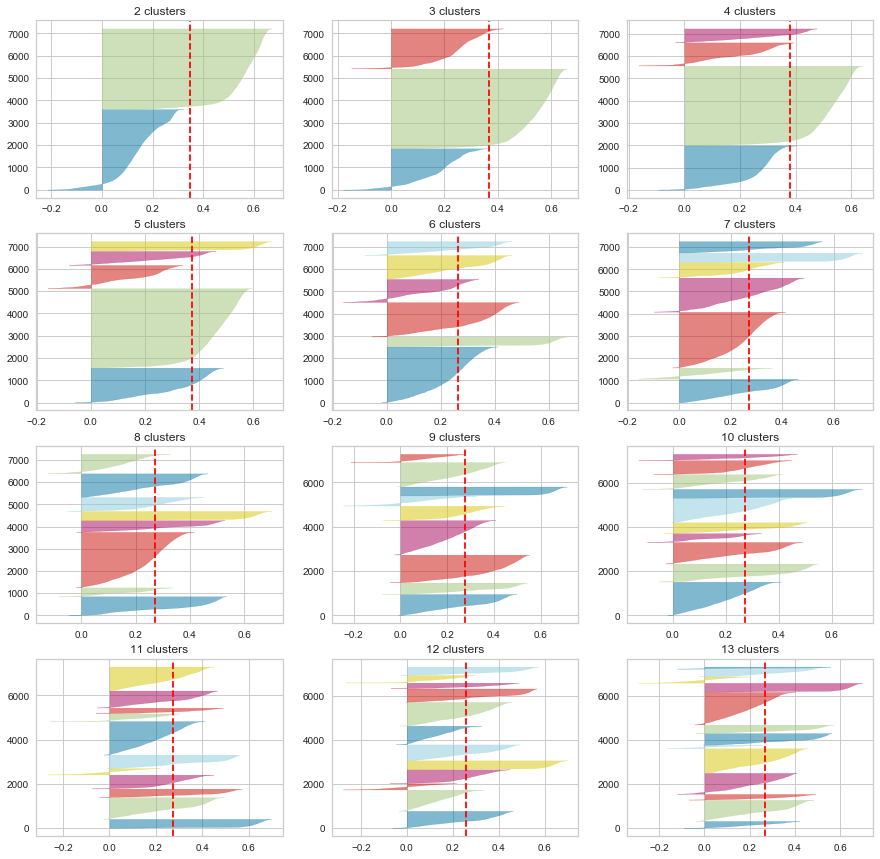

Wall time: 48.7 s


In [7]:
%%time
# Посчитаем сумму квадратов от объектов до центров кластеров - inertia и силуэты для кластеров от 2 до 13
inertia = []
silhouette = []
labels = {}
V_Family, V_Genus, V_Species = [], [], []

# Перекодируем все метки
label_true_Family = LabelEncoder().fit_transform(label_Family)
label_true_Genus = LabelEncoder().fit_transform(label_Genus)
label_true_Species = LabelEncoder().fit_transform(label_Species)

K = range(2,14)

# Визуализируем силуэты для всех объектов для разного количества кластеров.
# Поскольку есть три вида меток - семейство, род и вид лягушек, 
# то посчитаем после подбора числа кластеров метрику качества - V-меру для каждого класса при разном кол-ве кластеров
fig, axs = plt.subplots(4, 3, figsize=(15, 15))
j = 0
for i in K:
    ax = axs[j//3,j%3]
    KM = SilhouetteVisualizer(KMeans(n_clusters=i),colors='yellowbrick', ax=ax).fit(df)
    ax.set_title('{} clusters'.format(i))
    j += 1
    inertia.append(KM.inertia_)
    silhouette.append(silhouette_score(df, KM.labels_))
    labels[i] = KM.labels_
    V_Family.append(v_measure_score(label_true_Family, KM.labels_))
    V_Genus.append(v_measure_score(label_true_Genus, KM.labels_))
    V_Species.append(v_measure_score(label_true_Species, KM.labels_))
plt.show()
# На всех графиках присутствует разброс силуэтов между кластерами - идеальных вариантов нет, 
# начиная с пяти кластеров разброс чуть падает, начиная с шести кластеров падает и среднее значение силуэта по всей выборке

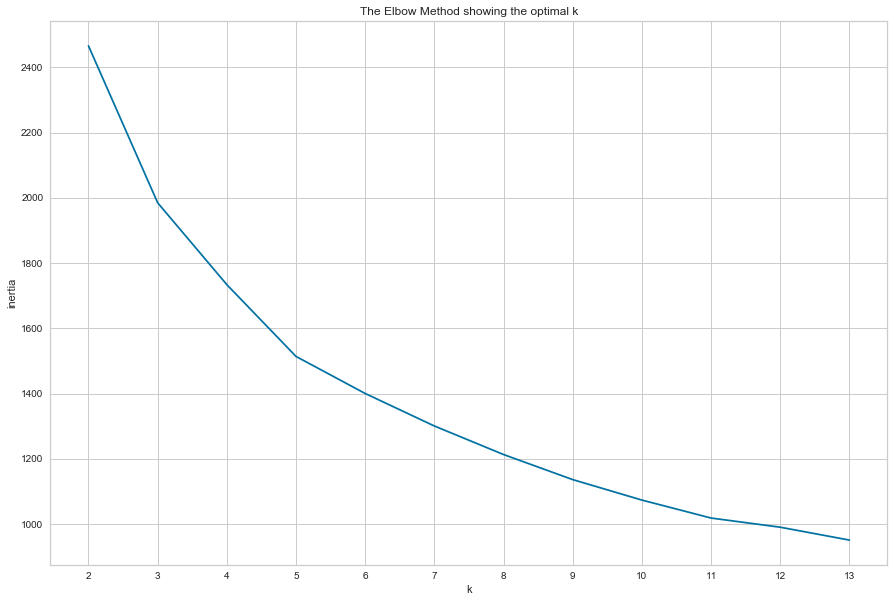

In [8]:
# Посмотрим на inertia в зависимости от числа кластеров
plt.figure(figsize=(15,10))
plt.plot(K, inertia, markevery=K)
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('The Elbow Method showing the optimal k')
plt.xticks(K)
plt.show()
# inertia постепенно убывает, по ней не определить оптимальное число кластеров

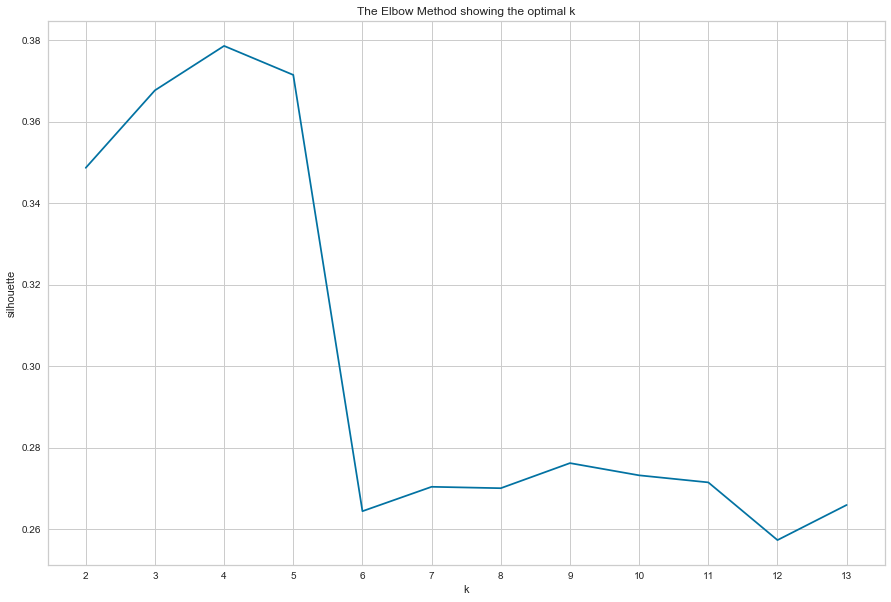

In [9]:
# Посмотрим на силуэт в зависимости от числа кластеров
plt.figure(figsize=(15,10))
plt.plot(K, silhouette)
plt.xlabel('k')
plt.ylabel('silhouette')
plt.title('The Elbow Method showing the optimal k')
plt.xticks(K)
plt.show()

#### Силуэт резко падает от 5-ти до 6-ти кластеров, кроме того с 5-ти кластеров чуть падает и разброс силуэта между самими кластерами, значит за оптимальное кол-во примем 5

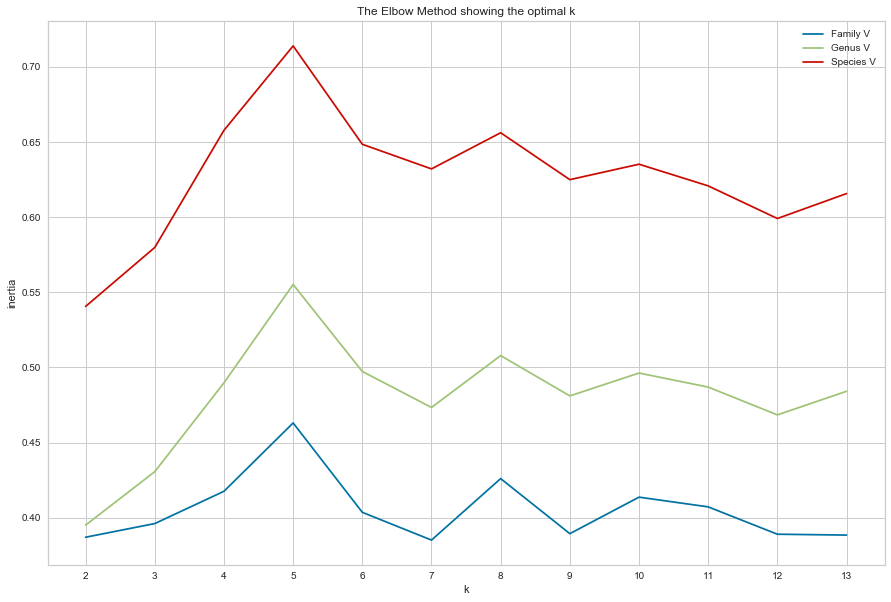

In [10]:
# Теперь посмотрим на V-меру(поскольку нам повезло и есть вохможные метки) в зависимости от числа кластеров
plt.figure(figsize=(15,10))
for i in [(V_Family, 'Family V'), (V_Genus, 'Genus V'), (V_Species, 'Species V')]:
    plt.plot(K, i[0], label = i[1])
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('The Elbow Method showing the optimal k')
    plt.legend()
    plt.xticks(K)

### И действительно на пяти кластерах V-мера самая высокая на всех вариантах меток - семейство, род и вид

Wall time: 1.09 s


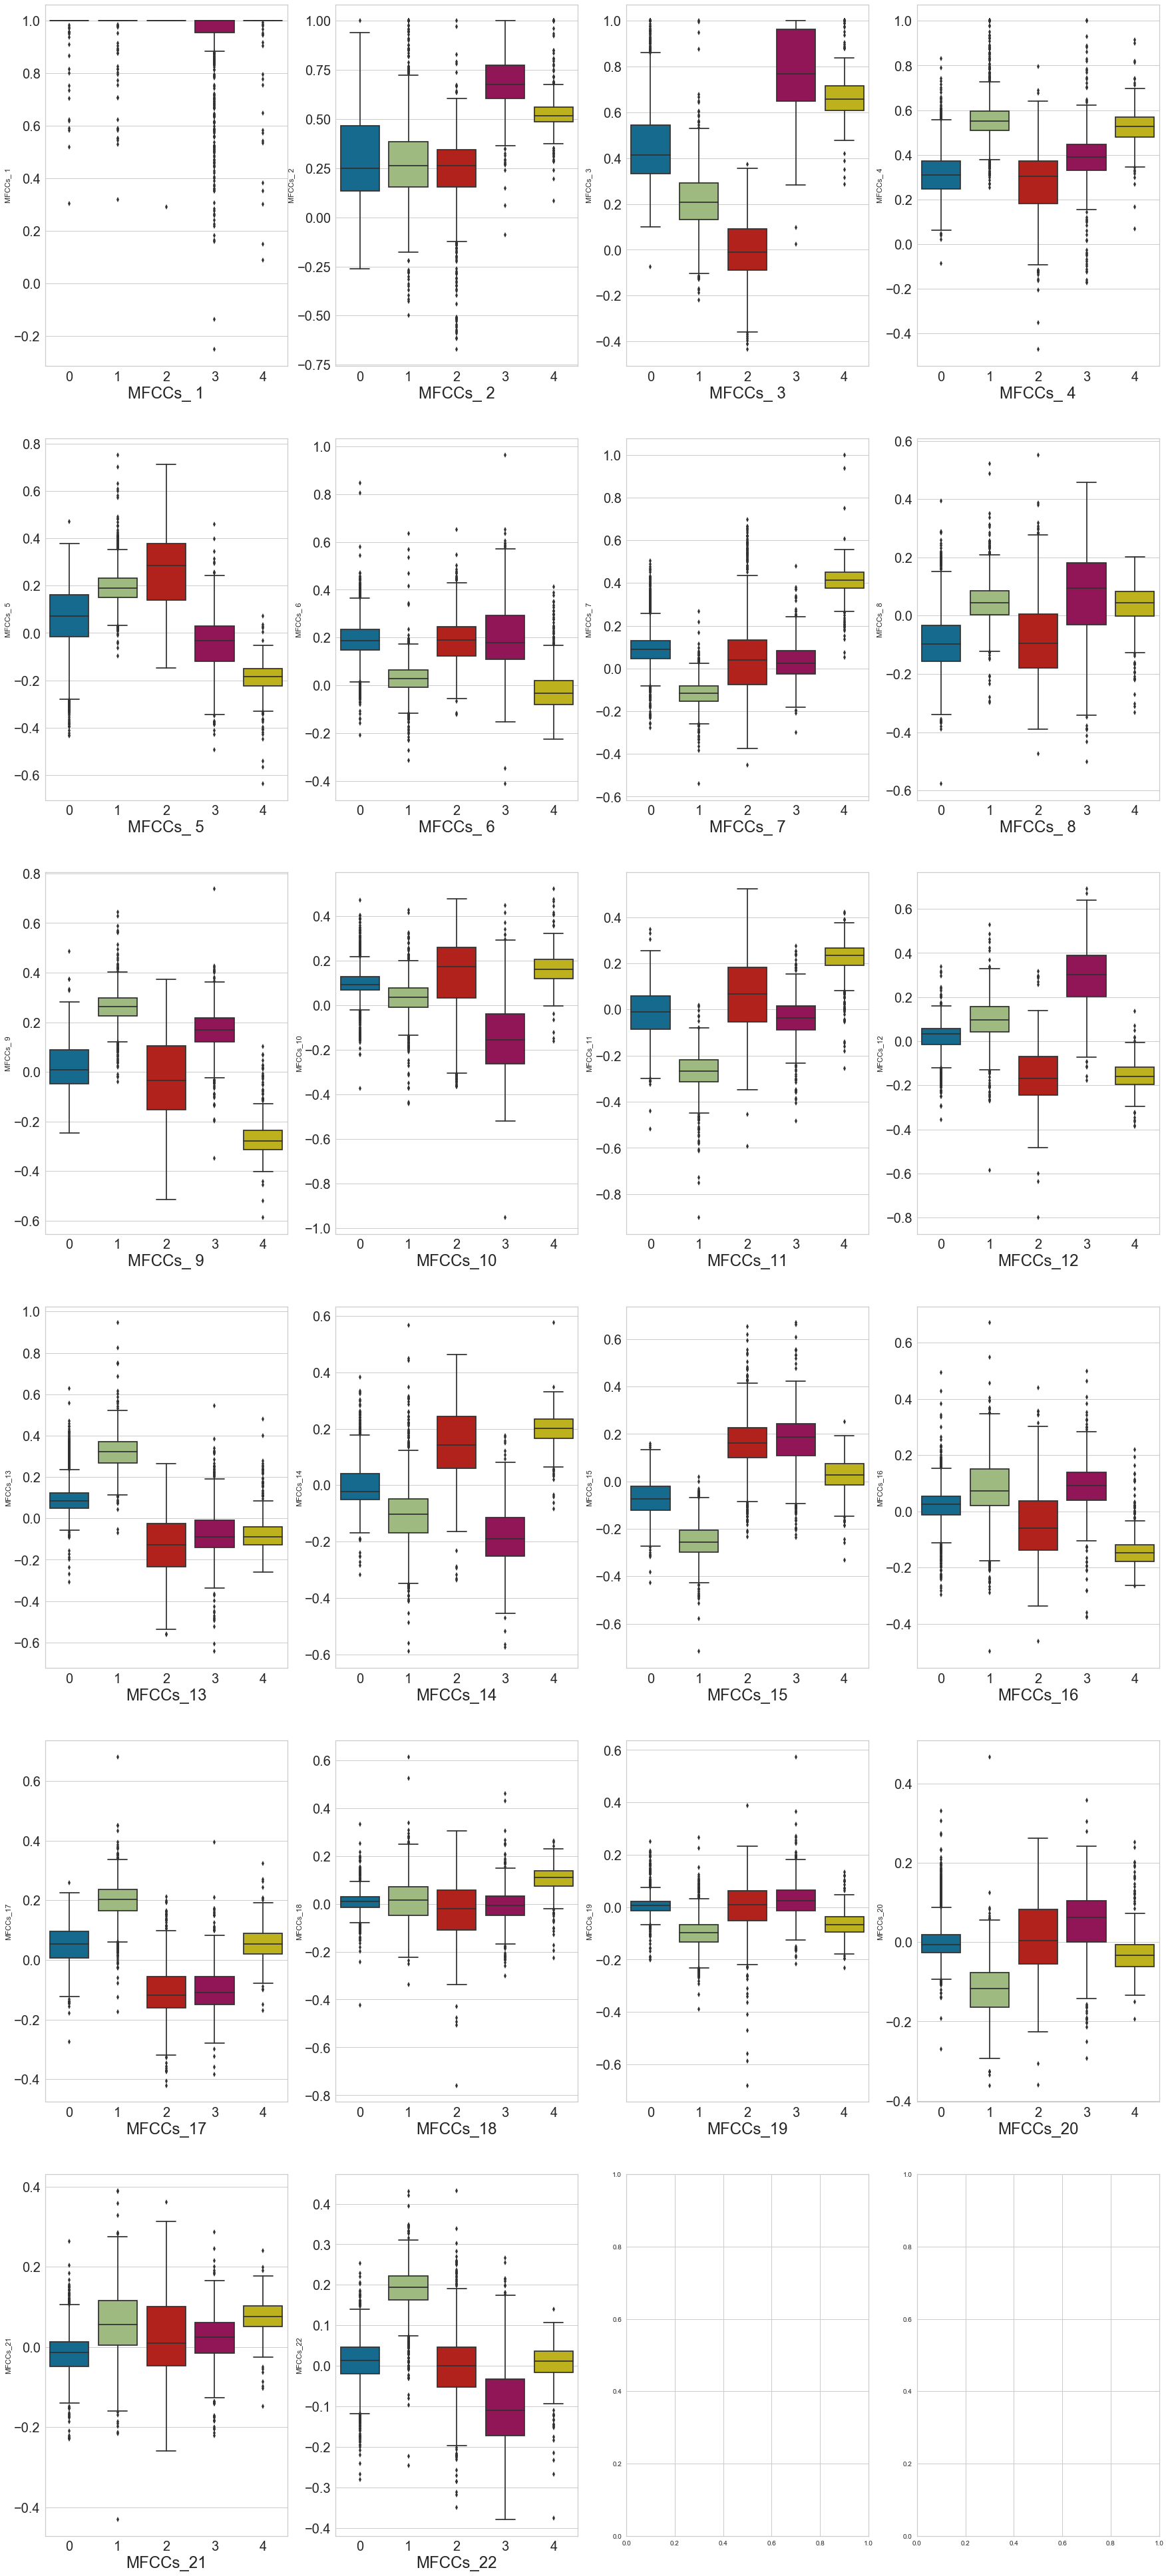

In [11]:
%%time
# Посмотрим распределение признаков на каждом кластере при пяти кластерах - построим boxplot 
fig, axs = plt.subplots(6, 4, figsize=(30, 70))
j = 0
for i in df.columns:
    ax = axs[j//4,j%4]
    ax= sns.boxplot(x=labels[5], y=i, ax=ax, data=df)
    ax.set_xlabel(i, size=24) 
    ax.tick_params(labelsize=20)
    j += 1